<a href="https://colab.research.google.com/github/zcasanova/datascience/blob/main/Traditional%20text%20classification%20with%20Scikit-learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Traditional" Text Classification with Scikit-learn

In this notebook, we're going to experiment with a few "traditional" approaches to text classification. These approaches pre-date the deep learning revolution in Natural Language Processing, but are often quick and effective ways of training a text classifier.

## Data

In [ ]:
!pip install datasets

For our data, we're going to work with the [20 Newsgroups data set](http://qwone.com/~jason/20Newsgroups/), a classic collection of text documents that is often used as a benchmark for text classification models. The set contains texts about various topics, ranging from computer hardward to religion. Some of the topics are closely related to each other (such as "IBM PC hardware" and "Mac hardware"), while others are very different (such as "religion" or "hockey"). The 20 Newsgroups comes shipped with the [Scikit-learn machine learning library](https://scikit-learn.org/stable/), our main tool for this exercise. It has been split into training set of 11,314 texts and a test set of 7,532 texts.

In [6]:

from datasets import load_dataset
dataset = load_dataset("newsgroup")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for newsgroup contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/newsgroup.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


ValueError: Config name is missing.
Please pick one among the available configs: ['18828_alt.atheism', '18828_comp.graphics', '18828_comp.os.ms-windows.misc', '18828_comp.sys.ibm.pc.hardware', '18828_comp.sys.mac.hardware', '18828_comp.windows.x', '18828_misc.forsale', '18828_rec.autos', '18828_rec.motorcycles', '18828_rec.sport.baseball', '18828_rec.sport.hockey', '18828_sci.crypt', '18828_sci.electronics', '18828_sci.med', '18828_sci.space', '18828_soc.religion.christian', '18828_talk.politics.guns', '18828_talk.politics.mideast', '18828_talk.politics.misc', '18828_talk.religion.misc', '19997_alt.atheism', '19997_comp.graphics', '19997_comp.os.ms-windows.misc', '19997_comp.sys.ibm.pc.hardware', '19997_comp.sys.mac.hardware', '19997_comp.windows.x', '19997_misc.forsale', '19997_rec.autos', '19997_rec.motorcycles', '19997_rec.sport.baseball', '19997_rec.sport.hockey', '19997_sci.crypt', '19997_sci.electronics', '19997_sci.med', '19997_sci.space', '19997_soc.religion.christian', '19997_talk.politics.guns', '19997_talk.politics.mideast', '19997_talk.politics.misc', '19997_talk.religion.misc', 'bydate_alt.atheism', 'bydate_comp.graphics', 'bydate_comp.os.ms-windows.misc', 'bydate_comp.sys.ibm.pc.hardware', 'bydate_comp.sys.mac.hardware', 'bydate_comp.windows.x', 'bydate_misc.forsale', 'bydate_rec.autos', 'bydate_rec.motorcycles', 'bydate_rec.sport.baseball', 'bydate_rec.sport.hockey', 'bydate_sci.crypt', 'bydate_sci.electronics', 'bydate_sci.med', 'bydate_sci.space', 'bydate_soc.religion.christian', 'bydate_talk.politics.guns', 'bydate_talk.politics.mideast', 'bydate_talk.politics.misc', 'bydate_talk.religion.misc']
Example of usage:
	`load_dataset('newsgroup', '18828_alt.atheism')`

In [ ]:
!tar -xzvf /content/20news-18828.tar.gz

In [5]:
from sklearn.datasets import fetch_20newsgroups
news_path = "/content/20news-18828"
train_data = fetch_20newsgroups(subset='train', data_home=news_path)
test_data = fetch_20newsgroups(subset='test', data_home=news_path)

print("Training texts:", len(train_data.data))
print("Test texts:", len(test_data.data))

Training texts: 11314
Test texts: 7532


## Preprocessing

The first step in the development of any NLP model is text preprocessing. This means we're going to transform our texts from word sequences to feature vectors. These feature vectors contain their values for each of a large number of features.

In this experiment, we're going to work with so-called "bag-of-word" approaches. Bag-of-word methods treat every text as an unordered collection of words (or optionally, ngrams), and the raw feature vectors simply tell us how often each word (or ngram) occurs in a text. In Scikit-learn, we can construct these raw feature vectors with the `CountVectorizer`, which tokenizes a text and counts the number of times any given text contains every token in the corpus.

However, these raw counts are not very informative yet. This is because the raw feature vectors of most texts in the same language will be very similar. For example, most texts in English contain many instances of relatively uninformative words, such as *a*, *the* or *be*. Instead, what we're interested in are words like *computer* or *hardware*: words that occur often in one text, but not very often in the corpus as a whole. Therefore we're going to weight all features by their [tf-idf score](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), which counts the number of times every token appears in a text and divides it by (the logarithm of) the percentage of corpus documents that contain that token. This weighting is performed by Scikit-learn's `TfidfTransformer`.

To obtain the weighted feature vectors, we combine the `CountVectorizer` and `TfidfTransformer` in a `Pipeline`, and fit this pipeline on the training data. We then transform both the training texts and the test texts to a collection of such weighted feature vectors. Scikit-learn also has a `TfidfVectorizer`, which achieves the same result as our pipeline.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

preprocessing = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])

print("Preprocessing training data...")
train_preprocessed = preprocessing.fit_transform(train_data.data)

print("Preprocessing test data...")
test_preprocessed = preprocessing.transform(test_data.data)

Preprocessing training data...
Preprocessing test data...


## Training

Next, we train a text classifier on the preprocessed training data. We're going to experiment with three classic text classification models: Naive Bayes, Support Vector Machines and Logistic Regression.

[Naive Bayes classifiers](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) are extremely simple classifiers that assume all features are independent of each other. They just learn how frequent all classes are and how frequently each feature occurs in a class. To classify a new text, they simply multiply the probabilities for every feature $x_i$ given each class $C$ and pick the class that gives the highest probability:

\begin{equation*}
\hat y = argmax_k\  p(C_k) \prod_{i=1}^n p(x_i \mid C_k)
\end{equation*}

Naive Bayes Classifiers are very quick to train, but usually fall behind in terms of performance.

[Support Vector Machines](https://en.wikipedia.org/wiki/Support_vector_machine) are much more advanced than Naive Bayes classifiers. They try to find the hyperplane in the feature space that best separates the data from the different classes. They do so by picking the hyperplane that maximizes the distance to the nearest data point on each side. When the classes are not linearly separable, SVMs map the data into a higher-dimensional space where a linear separation can hopefully be found. SVMs often achieve very good performance in text classification tasks.

[Logistic Regression models](https://en.wikipedia.org/wiki/Logistic_regression), finally, model the log-odds $l$, or $log(p/(1-p))$, of a class as a linear model and estimate the parameters $\beta$ of the model during training:

\begin{equation*}
l = \beta_0 + \sum_{i=1}^n \beta_i x_i
\end{equation*}

Like SVMs, they often achieve great performance in text classification.

### Simple training

We train our three classifiers in Scikit-learn with the `fit` method, giving it the preprocessed training text and the correct classes for each text as parameters.

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

nb_classifier = MultinomialNB()
svm_classifier = LinearSVC()
lr_classifier = LogisticRegression(multi_class="ovr")

print("Training Naive Bayes classifier...")
nb_classifier.fit(train_preprocessed, train_data.target)

print("Training SVM classifier...")
svm_classifier.fit(train_preprocessed, train_data.target)

print("Training Logistic Regression classifier...")
lr_classifier.fit(train_preprocessed, train_data.target)

Training Naive Bayes classifier...
Training SVM classifier...
Training Logistic Regression classifier...


LogisticRegression(multi_class='ovr')

Let's find out how well each classifier performs. To find oud, we have each classifier `predict` the label for all texts in our preprocessed test set.

In [8]:
nb_predictions = nb_classifier.predict(test_preprocessed)
svm_predictions = svm_classifier.predict(test_preprocessed)
lr_predictions = lr_classifier.predict(test_preprocessed)

In [11]:
best_svm_predictions = svm_predictions
best_lr_predictions = lr_predictions

Now we can compute the accuracy of each model: the proportion of test texts for which the predicted label is the same as the target label. The Naive Bayes classifier assigned the correct label in 77.4% of the cases, the logistic regression model achieves an accuracy of 82.8%, and the Support Vector Machine got the label right 85.3% of the time.

In [9]:
import numpy as np

print("NB Accuracy:", np.mean(nb_predictions == test_data.target))
print("SVM Accuracy:", np.mean(svm_predictions == test_data.target))
print("LR Accuracy:", np.mean(lr_predictions == test_data.target))

NB Accuracy: 0.7738980350504514
SVM Accuracy: 0.8531598513011153
LR Accuracy: 0.8278013807753585


### Grid search

Still, it's a bit too early to announce the winner. It's very likely we haven't yet got the most from our classifiers. When we trained them above, we just used the default values for most hyperparameters. However, these hyperparameter values can have a big impact on accuracy. Therefore we want to explore the parameter space a bit more extensively, and find out what hyperparameter values give the best results. We do this with so-called grid search. In grid search, we define a grid of hyperparameter values that we want to explore. Scikit-learn then steps to this grid to find the best combination. It does this with $n$-fold cross-validation: for each parameter combination in the grid, it fits a predefined number of models ($n$, the `cv` parameter in `GridSearchCV`. It splits up the training data in $n$ folds, fits a model on all but one of these folds, and tests it on the held-out fold. When it has done this $n$ times, it computes the average performance, and moves on. It performs the full hyperparameter grid in this way and keeps the model with the best average performance over the folds.

In this example, we'll experiment with the $C$ hyperparameter. $C$ controls the degree of regularization in support vector machines and logistic regression. Regularization combats overfitting by imposing a penalty on large parameter values in the model. The lower the $C$ value, the more regularization is applied.

In [10]:
from sklearn.model_selection import GridSearchCV

parameters = {'C': np.logspace(0, 3, 10)}
parameters = {'C': [0.1, 1, 10, 100, 1000]}

print("Grid search for SVM")
svm_best = GridSearchCV(svm_classifier, parameters, cv=3, verbose=1)
svm_best.fit(train_preprocessed, train_data.target)

print("Grid search for logistic regression")
lr_best = GridSearchCV(lr_classifier, parameters, cv=3, verbose=1)
lr_best.fit(train_preprocessed, train_data.target)

Grid search for SVM
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


KeyboardInterrupt: 

When grid search has been completed, we can find out what hyperparameter values led to the best-performing model.

In [ ]:
print("Best SVM Parameters")
print(svm_best.best_params_)

print("Best LR parameters:")
print(lr_best.best_params_)

Let's see if these best models now perform any better on our test data. For the SVM, the default setting seems to have worked best: our other values didn't lead to a higher accuracy. For logistic regression, however, the default $C$ value was clearly not the most optimal one. When we increase $C$ to $1000$, the logistic regression model performs almost as well as the SVM.

In [12]:
best_svm_predictions = svm_best.predict(test_preprocessed)
best_lr_predictions = lr_best.predict(test_preprocessed)

print("Best SVM Accuracy:", np.mean(best_svm_predictions == test_data.target))
print("Best LR Accuracy:", np.mean(best_lr_predictions == test_data.target))

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## Extensive evaluation

### Detailed scores

So far we've only looked at the accuracy of our models: the proportion of test examples for which their prediction is correct. This is fine as a first evaluation, but it doesn't give us much insight in what mistakes the models make and why. We'll therefore perform a much more extensive evaluation, in three steps. Let's start by computing the precision, recall and F-score of the best SVM for the individual classes:

- Precision is the number of times the classifier predicted a class correctly, divided by the total number of times it predicted this class.
- Recall is the proportion of documents with a given class that were labelled correctly by the classifier.
- The F1-score is the harmonic mean between precision and recall: $2*P*R/(P+R)$

The classification report below shows, for example, that the sports classes were quite easy to predict, while the computer and some of the politics classes proved much more difficult.

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(test_data.target, best_svm_predictions, target_names=test_data.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.82      0.80      0.81       319
           comp.graphics       0.76      0.80      0.78       389
 comp.os.ms-windows.misc       0.77      0.73      0.75       394
comp.sys.ibm.pc.hardware       0.71      0.76      0.74       392
   comp.sys.mac.hardware       0.84      0.86      0.85       385
          comp.windows.x       0.87      0.76      0.81       395
            misc.forsale       0.83      0.91      0.87       390
               rec.autos       0.92      0.91      0.91       396
         rec.motorcycles       0.95      0.95      0.95       398
      rec.sport.baseball       0.92      0.95      0.93       397
        rec.sport.hockey       0.96      0.98      0.97       399
               sci.crypt       0.93      0.94      0.93       396
         sci.electronics       0.81      0.79      0.80       393
                 sci.med       0.90      0.87      0.88       396
         

### Confusion matrix

Second, we're going to visualize our results in even more detail, using a so-called confusion matrix. A confusion matrix helps us better understand the errors our classifier makes. Its rows display the actual labels, its columns show the predictions of our classifier. This means all correct predictions will lie on the diagonal, where the actual label and the predicted label are the same. The predictions elsewhere in the matrix help us understand what classes are often mixed up by our classifier. Our confusion matrix shows, for example, that 91 documents with the label `talk.politics.misc` incorrectly received the label `talk.politics.guns`. Similarly, our classifier sometimes fails to tell apart the two religion classes, and gets quite mixed up in the computer topics in the top left corner.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 [Text(0.5, 0, 'alt.atheism'),
  Text(1.5, 0, 'comp.graphics'),
  Text(2.5, 0, 'comp.os.ms-windows.misc'),
  Text(3.5, 0, 'comp.sys.ibm.pc.hardware'),
  Text(4.5, 0, 'comp.sys.mac.hardware'),
  Text(5.5, 0, 'comp.windows.x'),
  Text(6.5, 0, 'misc.forsale'),
  Text(7.5, 0, 'rec.autos'),
  Text(8.5, 0, 'rec.motorcycles'),
  Text(9.5, 0, 'rec.sport.baseball'),
  Text(10.5, 0, 'rec.sport.hockey'),
  Text(11.5, 0, 'sci.crypt'),
  Text(12.5, 0, 'sci.electronics'),
  Text(13.5, 0, 'sci.med'),
  Text(14.5, 0, 'sci.space'),
  Text(15.5, 0, 'soc.religion.christian'),
  Text(16.5, 0, 'talk.politics.guns'),
  Text(17.5, 0, 'talk.politics.mideast'),
  Text(18.5, 0, 'talk.politics.misc'),
  Text(19.5, 0, 'talk.religion.misc')])

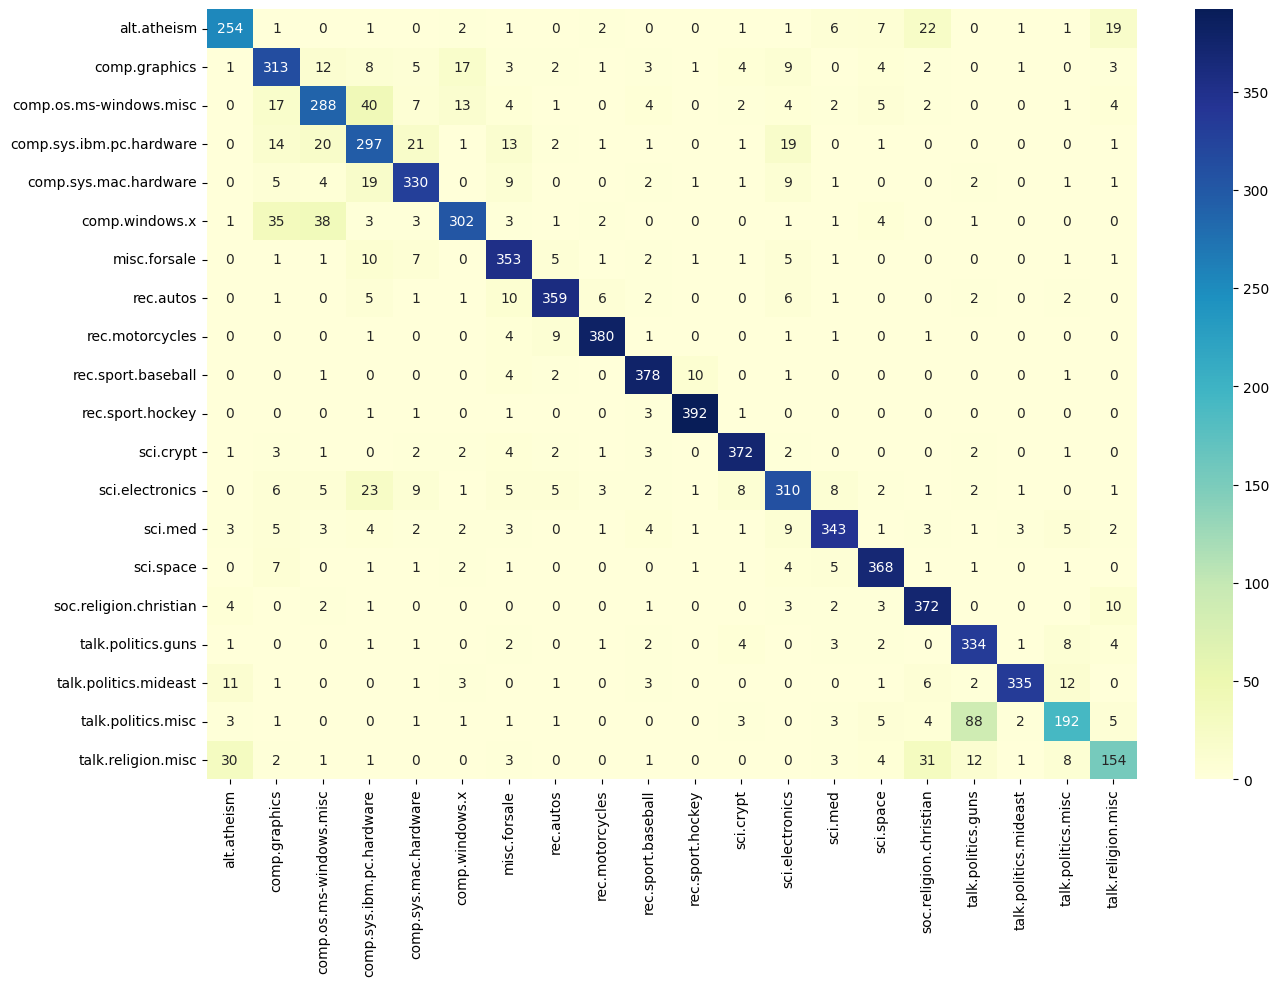

In [14]:
%matplotlib inline
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(test_data.target, best_svm_predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=test_data.target_names, columns=test_data.target_names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

### Explainability

Finally, we'd like to perform a more qualitative evaluation of our model by taking a look at the features that it assigns the highest weight for each of the classes. This will help us understand if the model indeed captures the phenomena we'd like it to capture. A great Python library to do this is `eli5`, which works together seamlessly with `scikit-learn`. Its `explain_weights` function takes a trained model, a list of feature names and target names, and prints out the features that have the highest positive values for each of the targets. The results convince us that our SVM indeed models the correct information: it sees a strong link between the "atheism" class and words such as _atheism_ and _atheists_, between "computer graphics" and words such as _3d_ and _image_, and so on.

In [15]:
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107720 sha256=41a68a4393117caf3d39f9e02f8e33d6d7a62146cd6920019b9cb55fa6d2b84a
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
import eli5

eli5.explain_weights(svm_best.best_estimator_,
                     feature_names = preprocessing.named_steps["vect"].get_feature_names(),
                     target_names = train_data.target_names
                    )

## Conclusions

This notebook has demonstrated how you can quickly train a text classifier. Although the types of models we've looked at predate the deep learning revolution in NLP, they're often a quick and effective way of training a first classifier for your text classification problem. Not only can they provide a good baseline and help you understand your data and problem better. In some cases, you may find they are quite hard to beat even with state-of-the-art deep learning models.